<a href="https://colab.research.google.com/github/zahidhamidi/ML-Project/blob/main/Testing_Pre_trained_Model_Binary_False_Positive_Case_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import re
import spacy
from gensim import corpora, models
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
nlp = spacy.load("en_core_web_sm")

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.12.0
Eager mode:  True
Hub version:  0.14.0
GPU is NOT AVAILABLE


In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Clear the TensorFlow session and reset the computational graph
tf.keras.backend.clear_session()

In [3]:
# Specify the path to the CSV file
csv_file_path = '/content/true_positive_experimentation.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Extract the text data from the 'text' column
text_data = df['doc_text_original'].tolist()

In [4]:
def preprocess_text(text):
    if not isinstance(text, str):
        # Handle non-string elements here, for example, by returning an empty string
        return ""

    # Replace contractions
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"n't", " not", text)

    # Remove special characters using regular expressions
    text = re.sub(r'[^\w\s]', '', text)

    doc = nlp(text)
    tokens = []

    for token in doc:
        # If the token is in title case (first letter uppercase, rest lowercase),
        # convert it to lowercase and keep only the first letter.
        if token.text.istitle():
            tokens.append(token.text[0].lower())
        else:
            tokens.append(token.lemma_)

    return " ".join(tokens)

# Apply preprocessing to the DataFrame, including removing NaN values
df['preprocessed_data'] = df['doc_text_original'].apply(preprocess_text)

# Filter out rows with empty strings (resulting from non-string elements)
df = df[df['preprocessed_data'] != ""]

# Filter out non-string elements from text_data and preprocess the rest
preprocessed_data = [preprocess_text(text) for text in text_data if isinstance(text, str)]

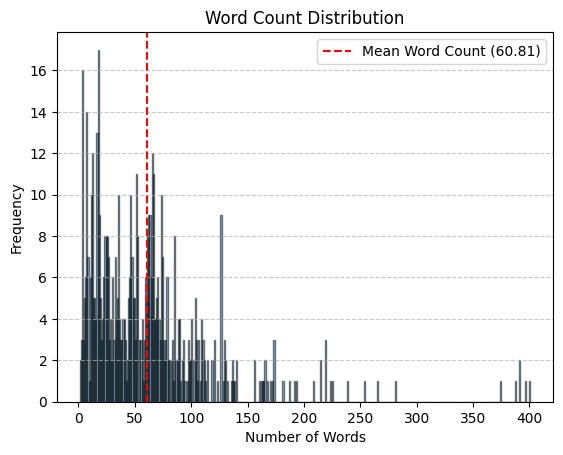

In [5]:
# Calculate the number of words per list item
word_counts = [len(text.split()) for text in preprocessed_data]

# Calculate the mean word count
mean_word_count = sum(word_counts) / len(word_counts)

# Create a histogram to visualize the distribution of word counts
plt.hist(word_counts, bins=range(1, max(word_counts) + 2), alpha=0.5, edgecolor='black')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Word Count Distribution')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a vertical dashed red line for the mean
plt.axvline(x=mean_word_count, color='red', linestyle='--', label=f'Mean Word Count ({mean_word_count:.2f})')

# Display a legend
plt.legend()

plt.show()

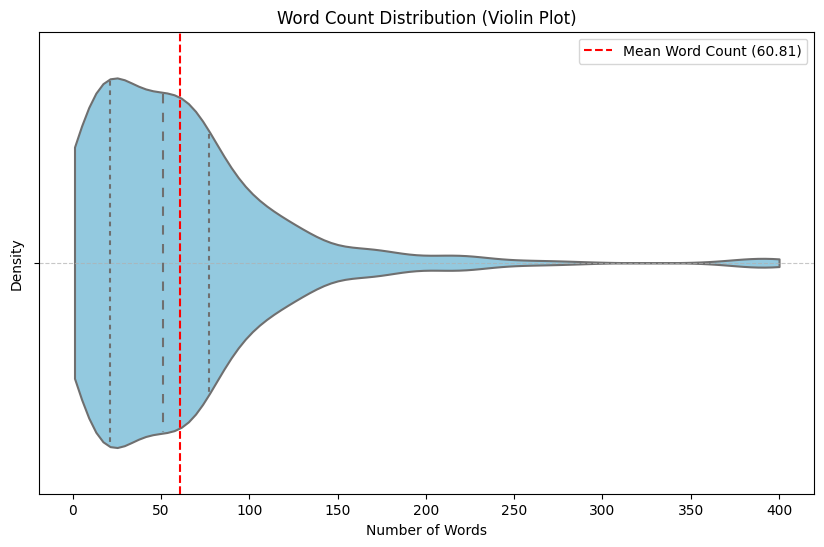

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the number of words per list item
word_counts = [len(text.split()) for text in preprocessed_data]

# Create a violin plot to visualize the distribution of word counts
plt.figure(figsize=(10, 6))
sns.violinplot(x=word_counts, inner='quart', cut=0, color='skyblue')

# Calculate the mean word count
mean_word_count = sum(word_counts) / len(word_counts)

# Add a vertical dashed red line for the mean
plt.axvline(x=mean_word_count, color='red', linestyle='--', label=f'Mean Word Count ({mean_word_count:.2f})')

# Add labels and title
plt.xlabel('Number of Words')
plt.ylabel('Density')
plt.title('Word Count Distribution (Violin Plot)')

# Display a legend
plt.legend()

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


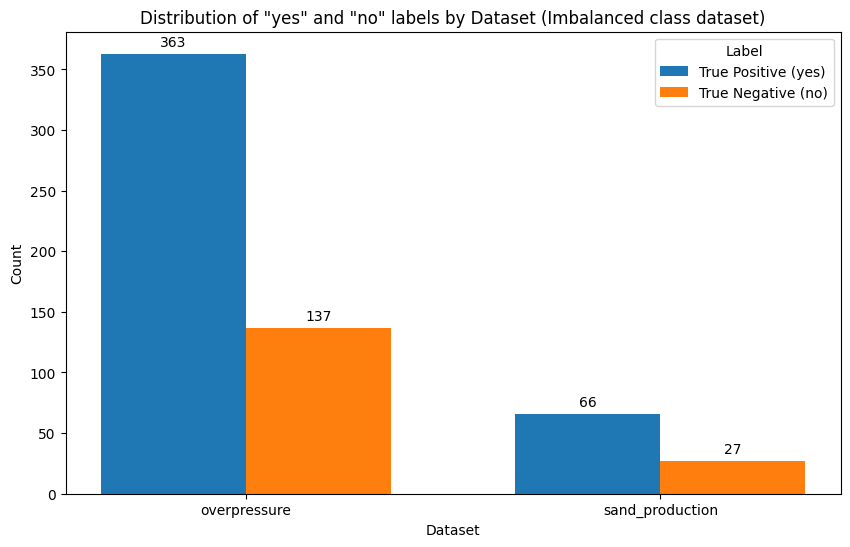

In [7]:
# Pivot the DataFrame to get "yes" and "no" counts as separate columns
pivot_df = df.pivot_table(index='dataset', columns='label', aggfunc='size', fill_value=0)

# Get the unique dataset names
datasets = pivot_df.index

# Number of bars in the bar chart
n = len(datasets)

# Width of each bar
width = 0.35

# Create an array of x values for the bars
x = np.arange(n)

# Create the side-by-side bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plot "yes" bars
yes_bars = ax.bar(x - width/2, pivot_df['yes'], width, label='True Positive (yes)')

# Plot "no" bars
no_bars = ax.bar(x + width/2, pivot_df['no'], width, label='True Negative (no)')

# Set x-axis labels to be the dataset names
ax.set_xticks(x)
ax.set_xticklabels(datasets)

# Add labels and title
plt.xlabel('Dataset')
plt.ylabel('Count')
plt.title('Distribution of "yes" and "no" labels by Dataset (Imbalanced class dataset)')

# Add legend
plt.legend(title='Label')

# Label the values on top of each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(yes_bars)
add_labels(no_bars)

# Show the plot
plt.show()

In [8]:
df

,id,result_id,source_name,source_type,name,basin,field_name,operator,longitude_decimal_degree,longitude_degree,...,article_title,document_id,document_title,page_number,dataset,label,label_code,predicted,doc_text_original,preprocessed_data
0,0,0456b65e-a8c6-4781-921f-5866299ba7bb,25/4-6 S,NORTHERN NORTH SEA,VALE,ELF PETROLEUM NORGE AS,NaN,2.0,18.0,58.410,...,Public Databases,48c62cc2-ce52-4aa4-8ea0-693a91c3503b,25_4-6_S__WELL__25-04-6S_PB-706-0881.PDF,16,overpressure,yes,1,NaN,The Statfjord reservoir is overpressured (emw ...,t s reservoir be overpressure emw 161 6444 b...
1,1,5449525e-55e3-4393-a0a7-8491131ac9ec,25/4-6 S,NORTHERN NORTH SEA,VALE,ELF PETROLEUM NORGE AS,NaN,2.0,18.0,58.410,...,Public Databases,48c62cc2-ce52-4aa4-8ea0-693a91c3503b,25_4-6_S__WELL__25-04-6S_PB-706-0881.PDF,16,overpressure,yes,1,NaN,‘ The Brent reservoir is overpressured (emw 1...,t b reservoir be overpressure emw 167 61...
2,2,5e2c63ca-eeae-4a67-9bec-0cbb1b019fdf,25/4-6 S,NORTHERN NORTH SEA,VALE,ELF PETROLEUM NORGE AS,NaN,2.0,18.0,58.410,...,Public Databases,48c62cc2-ce52-4aa4-8ea0-693a91c3503b,25_4-6_S__WELL__25-04-6S_PB-706-0881.PDF,109,overpressure,yes,1,NaN,"» Finally, the core measurements have not been...",f the core measurement have not be overburde...
3,3,a5673f0a-1d95-4200-84cd-bbbd61de1ddc,25/4-6 S,NORTHERN NORTH SEA,VALE,ELF PETROLEUM NORGE AS,NaN,2.0,18.0,58.410,...,Public Databases,48c62cc2-ce52-4aa4-8ea0-693a91c3503b,25_4-6_S__WELL__25-04-6S_PB-706-0881.PDF,110,overpressure,yes,1,NaN,Also if the pressure in the Lower Unit should ...,a if the pressure in the l u should be correct...
4,4,3115cbd3-2cf1-4a95-b560-d943430459f3,25/4-6 S,NORTHERN NORTH SEA,VALE,ELF PETROLEUM NORGE AS,NaN,2.0,18.0,58.410,...,Public Databases,48c62cc2-ce52-4aa4-8ea0-693a91c3503b,25_4-6_S__WELL__25-04-6S_PB-706-0881.PDF,110,overpressure,yes,1,NaN,As regards the two pressures obtained in the w...,a regard the two pressure obtain in the water ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,469,11697109-db6e-47f9-9afa-0351754eccb3,CHALLIS-8,BONAPARTE,CHALLIS,BHP PETROLEUM PTY LTD,125.049078,NaN,NaN,NaN,...,Public Databases,48dca10d-7ca2-4c35-aefc-0faaca172e70,Challis_8_WCR_Interpretive_I00029770.pdf,189,sand_production,yes,1,NaN,'Challis-B was drilled in March-April 1989 to ...,ChallisB be drill in MarchApril 1989 to apprai...
589,489,7c41dc29-2bf2-447f-b674-92eceb172c91,PUFFIN-5,BONAPARTE,PUFFIN,AEC INTERNATIONAL (AUSTRALIA) PTY LTD,124.327837,NaN,NaN,NaN,...,Public Databases,93a81f54-1ad0-4975-b1f4-6ca39dc689eb,Puffin5_finalWCR_interp.pdf,37,sand_production,yes,1,NaN,'Schlumberger conducted one drill stem test (D...,s conduct one drill stem test DST over the int...
590,490,bffb6b68-e477-4285-8839-514fac0182a6,BLACKTIP-P2,BONAPARTE,BLACKTIP,ENI AUSTRALIA B.V.,128.484116,128.0,29.0,2.816,...,Public Databases,9e76f2d4-82d7-45a7-9abe-5297f694179e,Blacktip_P2_Well_Completion_Report_Basic_Data.pdf,711,sand_production,yes,1,NaN,'The sand/erosion probe was installed in a spo...,t sanderosion probe be instal in a spool that ...
591,491,274e62d3-41a2-4552-a19d-7c4f01d02beb,BLACKTIP-P2,BONAPARTE,BLACKTIP,ENI AUSTRALIA B.V.,128.484116,128.0,29.0,2.816,...,Public Databases,9e76f2d4-82d7-45a7-9abe-5297f694179e,Blacktip_P2_Well_Completion_Report_Basic_Data.pdf,711,sand_production,yes,1,NaN,'The sand/erosion probe was installed in a spo...,t sanderosion probe be instal in a spool that ...


In [9]:
""""
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

# Sample list of preprocessed sentences and labels

labels = df["label_code"].tolist()
dataset = df["dataset"].tolist()

# Create a DataFrame from the preprocessed data
df2 = pd.DataFrame({"dataset" : dataset,"text": preprocessed_data, "label_code": labels})

# Separate the data into two DataFrames based on the dataset
sand_production_df = df2[df2["dataset"] == "sand_production"]
overpressure_df = df2[df2["dataset"] == "overpressure"]

# Instantiate a CountVectorizer to convert text data to numerical features for sand_production
vectorizer_sand = CountVectorizer()
X_sand = vectorizer_sand.fit_transform(sand_production_df["text"])
smote_sand = SMOTE(sampling_strategy="auto", random_state=42)
X_resampled_sand, y_resampled_sand = smote_sand.fit_resample(X_sand, sand_production_df["label_code"])
resampled_sand_df = pd.DataFrame({"text": vectorizer_sand.inverse_transform(X_resampled_sand), "label_code": y_resampled_sand})

# Instantiate a CountVectorizer to convert text data to numerical features for overpressure
vectorizer_overpressure = CountVectorizer()
X_overpressure = vectorizer_overpressure.fit_transform(overpressure_df["text"])
smote_overpressure = SMOTE(sampling_strategy="auto", random_state=42)
X_resampled_overpressure, y_resampled_overpressure = smote_overpressure.fit_resample(X_overpressure, overpressure_df["label_code"])
resampled_overpressure_df = pd.DataFrame(
    {"text": vectorizer_overpressure.inverse_transform(X_resampled_overpressure), "label_code": y_resampled_overpressure}
)

# Calculate the count of "yes" and "no" for sand_production after SMOTE
class_counts_sand = Counter(resampled_sand_df["label_code"])

# Calculate the count of "yes" and "no" for overpressure after SMOTE
class_counts_overpressure = Counter(resampled_overpressure_df["label_code"])

# Create two side-by-side bar plots
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(class_counts_sand.keys(), class_counts_sand.values(), color=["darkblue", "orange"])
plt.xlabel("Label")
plt.ylabel("Count")
plt.title('Distribution of "Yes" and "No" Labels for "sand_production" after SMOTE', y=1.02, fontsize = 10)  # Adjust the title position

# Display the counts on top of the bars for sand_production
for label, count in class_counts_sand.items():
    plt.text(label, count + 5, str(count), ha="center", va="top")

plt.subplot(1, 2, 2)
plt.bar(class_counts_overpressure.keys(), class_counts_overpressure.values(), color=["darkblue", "orange"])
plt.xlabel("Label")
plt.ylabel("Count")
plt.title('Distribution of "Yes" and "No" Labels for "overpressure" after SMOTE', y=1.02, fontsize = 10)  # Adjust the title position

# Display the counts on top of the bars for overpressure
for label, count in class_counts_overpressure.items():
    plt.text(label, count + 5, str(count), ha="center", va="bottom")

plt.tight_layout()
plt.show()
"""

'"\nimport pandas as pd\nimport matplotlib.pyplot as plt\nfrom imblearn.over_sampling import SMOTE\nfrom collections import Counter\nfrom sklearn.feature_extraction.text import CountVectorizer\n\n# Sample list of preprocessed sentences and labels\n\nlabels = df["label_code"].tolist()\ndataset = df["dataset"].tolist()\n\n# Create a DataFrame from the preprocessed data\ndf2 = pd.DataFrame({"dataset" : dataset,"text": preprocessed_data, "label_code": labels})\n\n# Separate the data into two DataFrames based on the dataset\nsand_production_df = df2[df2["dataset"] == "sand_production"]\noverpressure_df = df2[df2["dataset"] == "overpressure"]\n\n# Instantiate a CountVectorizer to convert text data to numerical features for sand_production\nvectorizer_sand = CountVectorizer()\nX_sand = vectorizer_sand.fit_transform(sand_production_df["text"])\nsmote_sand = SMOTE(sampling_strategy="auto", random_state=42)\nX_resampled_sand, y_resampled_sand = smote_sand.fit_resample(X_sand, sand_production_df[

In [10]:
combined_df = df


In [13]:
preprocessed_data = combined_df["doc_text_original"].tolist()

In [14]:
df["label_code"] = df["label_code"].astype(float)


In [15]:
# Testing with pre-trained model

# Load the pre-trained model from TensorFlow Hub
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
# embedding = "https://tfhub.dev/google/nnlm-en-dim128/2"
# embedding = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=False)

# Flatten and join the tokenized data into a single string for each document
X_test = [" ".join(doc) for doc in preprocessed_data]

# Define the number of models to average
num_models = 5  # You can adjust this based on your preference

# Create a list to store the models
models = []

# Train and store multiple models
for i in range(num_models):
    model = tf.keras.Sequential([
        hub_layer,
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model with binary cross-entropy loss and metric(s) of your choice
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Train the model on your data (replace with your actual training code)
    # model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_val, y_val))

    models.append(model)  # Store the trained model

# Make predictions using each model
predictions = []
for model in models:
    predictions.append(model.predict(X_test))

# Average the predictions
average_predictions = np.mean(predictions, axis=0)

# Assuming average_predictions contains probability scores, you can threshold them to get binary predictions
binary_predictions = (average_predictions > 0.5).astype(np.int32)

19/19 [==============================] - 0s 5ms/step


In [21]:
# Assuming 'binary_predictions' contains your binary predictions
# Ensure that the length of 'binary_predictions' matches the number of rows you want to update
num_rows_to_update = len(binary_predictions)

# Update the "predicted_label_code" column with the binary predictions for the first 'num_rows_to_update' rows
combined_df.loc[:num_rows_to_update - 1, 'predicted'] = binary_predictions



<ipython-input-21-94caca1489c7>:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  combined_df.loc[:num_rows_to_update - 1, 'predicted'] = binary_predictions


In [22]:
combined_df

,id,result_id,source_name,source_type,name,basin,field_name,operator,longitude_decimal_degree,longitude_degree,...,document_id,document_title,page_number,dataset,label,label_code,predicted,doc_text_original,preprocessed_data,predicted_label_code
0,0,0456b65e-a8c6-4781-921f-5866299ba7bb,25/4-6 S,NORTHERN NORTH SEA,VALE,ELF PETROLEUM NORGE AS,NaN,2.0,18.0,58.410,...,48c62cc2-ce52-4aa4-8ea0-693a91c3503b,25_4-6_S__WELL__25-04-6S_PB-706-0881.PDF,16,overpressure,yes,1.0,0,The Statfjord reservoir is overpressured (emw ...,t s reservoir be overpressure emw 161 6444 b...,0.0
1,1,5449525e-55e3-4393-a0a7-8491131ac9ec,25/4-6 S,NORTHERN NORTH SEA,VALE,ELF PETROLEUM NORGE AS,NaN,2.0,18.0,58.410,...,48c62cc2-ce52-4aa4-8ea0-693a91c3503b,25_4-6_S__WELL__25-04-6S_PB-706-0881.PDF,16,overpressure,yes,1.0,1,‘ The Brent reservoir is overpressured (emw 1...,t b reservoir be overpressure emw 167 61...,1.0
2,2,5e2c63ca-eeae-4a67-9bec-0cbb1b019fdf,25/4-6 S,NORTHERN NORTH SEA,VALE,ELF PETROLEUM NORGE AS,NaN,2.0,18.0,58.410,...,48c62cc2-ce52-4aa4-8ea0-693a91c3503b,25_4-6_S__WELL__25-04-6S_PB-706-0881.PDF,109,overpressure,yes,1.0,1,"» Finally, the core measurements have not been...",f the core measurement have not be overburde...,1.0
3,3,a5673f0a-1d95-4200-84cd-bbbd61de1ddc,25/4-6 S,NORTHERN NORTH SEA,VALE,ELF PETROLEUM NORGE AS,NaN,2.0,18.0,58.410,...,48c62cc2-ce52-4aa4-8ea0-693a91c3503b,25_4-6_S__WELL__25-04-6S_PB-706-0881.PDF,110,overpressure,yes,1.0,1,Also if the pressure in the Lower Unit should ...,a if the pressure in the l u should be correct...,1.0
4,4,3115cbd3-2cf1-4a95-b560-d943430459f3,25/4-6 S,NORTHERN NORTH SEA,VALE,ELF PETROLEUM NORGE AS,NaN,2.0,18.0,58.410,...,48c62cc2-ce52-4aa4-8ea0-693a91c3503b,25_4-6_S__WELL__25-04-6S_PB-706-0881.PDF,110,overpressure,yes,1.0,1,As regards the two pressures obtained in the w...,a regard the two pressure obtain in the water ...,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,469,11697109-db6e-47f9-9afa-0351754eccb3,CHALLIS-8,BONAPARTE,CHALLIS,BHP PETROLEUM PTY LTD,125.049078,NaN,NaN,NaN,...,48dca10d-7ca2-4c35-aefc-0faaca172e70,Challis_8_WCR_Interpretive_I00029770.pdf,189,sand_production,yes,1.0,1,'Challis-B was drilled in March-April 1989 to ...,ChallisB be drill in MarchApril 1989 to apprai...,1.0
589,489,7c41dc29-2bf2-447f-b674-92eceb172c91,PUFFIN-5,BONAPARTE,PUFFIN,AEC INTERNATIONAL (AUSTRALIA) PTY LTD,124.327837,NaN,NaN,NaN,...,93a81f54-1ad0-4975-b1f4-6ca39dc689eb,Puffin5_finalWCR_interp.pdf,37,sand_production,yes,1.0,1,'Schlumberger conducted one drill stem test (D...,s conduct one drill stem test DST over the int...,1.0
590,490,bffb6b68-e477-4285-8839-514fac0182a6,BLACKTIP-P2,BONAPARTE,BLACKTIP,ENI AUSTRALIA B.V.,128.484116,128.0,29.0,2.816,...,9e76f2d4-82d7-45a7-9abe-5297f694179e,Blacktip_P2_Well_Completion_Report_Basic_Data.pdf,711,sand_production,yes,1.0,1,'The sand/erosion probe was installed in a spo...,t sanderosion probe be instal in a spool that ...,1.0
591,491,274e62d3-41a2-4552-a19d-7c4f01d02beb,BLACKTIP-P2,BONAPARTE,BLACKTIP,ENI AUSTRALIA B.V.,128.484116,128.0,29.0,2.816,...,9e76f2d4-82d7-45a7-9abe-5297f694179e,Blacktip_P2_Well_Completion_Report_Basic_Data.pdf,711,sand_production,yes,1.0,1,'The sand/erosion probe was installed in a spo...,t sanderosion probe be instal in a spool that ...,1.0


In [24]:
# Assuming you have loaded your DataFrame 'df' with the columns 'label_code' and 'predicted_label_code'

# Calculate accuracy
correct_predictions = (combined_df['label_code'] == combined_df['predicted']).sum()
total_predictions = len(preprocessed_data)
accuracy = (correct_predictions / total_predictions) * 100

print(f"Number of correct predictions: {correct_predictions}")

print(f"Accuracy: {accuracy:.2f}%")


Number of correct predictions: 399
Accuracy: 67.28%


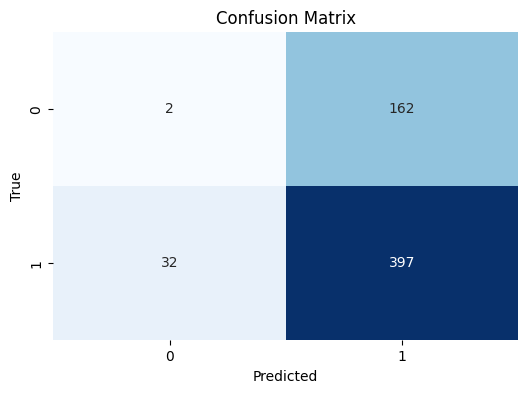

Accuracy: 0.67
Precision: 0.71
Recall: 0.93
F1 Score: 0.80


In [25]:
# Assuming you have loaded your DataFrame 'df' with the columns 'label_code' and 'predicted_label_code'
y_true = combined_df['label_code']
y_pred = combined_df['predicted_label_code']

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate additional evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Print evaluation metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

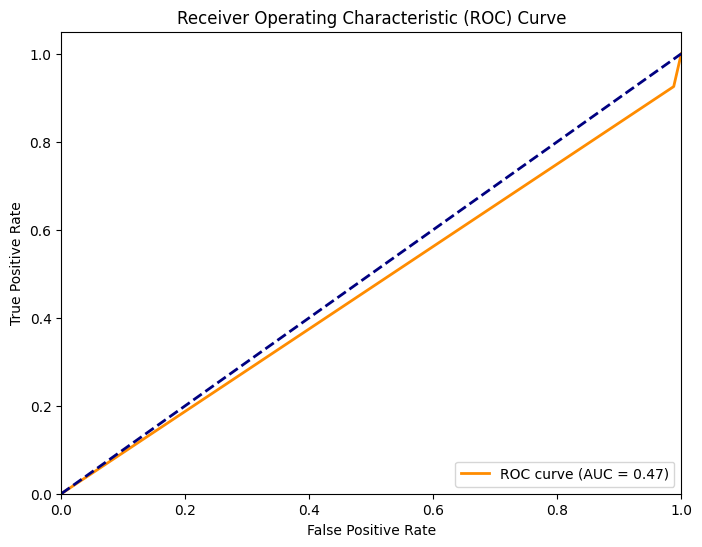

In [26]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have loaded your DataFrame 'df' with the columns 'label_code' and 'predicted_label_code'
y_true = combined_df['label_code']
y_score = combined_df['predicted_label_code']  # This should contain the predicted probabilities or scores

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [20]:
combined_df

,id,result_id,source_name,source_type,name,basin,field_name,operator,longitude_decimal_degree,longitude_degree,...,document_id,document_title,page_number,dataset,label,label_code,predicted,doc_text_original,preprocessed_data,predicted_label_code
0,0,0456b65e-a8c6-4781-921f-5866299ba7bb,25/4-6 S,NORTHERN NORTH SEA,VALE,ELF PETROLEUM NORGE AS,NaN,2.0,18.0,58.410,...,48c62cc2-ce52-4aa4-8ea0-693a91c3503b,25_4-6_S__WELL__25-04-6S_PB-706-0881.PDF,16,overpressure,yes,1.0,NaN,The Statfjord reservoir is overpressured (emw ...,t s reservoir be overpressure emw 161 6444 b...,0.0
1,1,5449525e-55e3-4393-a0a7-8491131ac9ec,25/4-6 S,NORTHERN NORTH SEA,VALE,ELF PETROLEUM NORGE AS,NaN,2.0,18.0,58.410,...,48c62cc2-ce52-4aa4-8ea0-693a91c3503b,25_4-6_S__WELL__25-04-6S_PB-706-0881.PDF,16,overpressure,yes,1.0,NaN,‘ The Brent reservoir is overpressured (emw 1...,t b reservoir be overpressure emw 167 61...,1.0
2,2,5e2c63ca-eeae-4a67-9bec-0cbb1b019fdf,25/4-6 S,NORTHERN NORTH SEA,VALE,ELF PETROLEUM NORGE AS,NaN,2.0,18.0,58.410,...,48c62cc2-ce52-4aa4-8ea0-693a91c3503b,25_4-6_S__WELL__25-04-6S_PB-706-0881.PDF,109,overpressure,yes,1.0,NaN,"» Finally, the core measurements have not been...",f the core measurement have not be overburde...,1.0
3,3,a5673f0a-1d95-4200-84cd-bbbd61de1ddc,25/4-6 S,NORTHERN NORTH SEA,VALE,ELF PETROLEUM NORGE AS,NaN,2.0,18.0,58.410,...,48c62cc2-ce52-4aa4-8ea0-693a91c3503b,25_4-6_S__WELL__25-04-6S_PB-706-0881.PDF,110,overpressure,yes,1.0,NaN,Also if the pressure in the Lower Unit should ...,a if the pressure in the l u should be correct...,1.0
4,4,3115cbd3-2cf1-4a95-b560-d943430459f3,25/4-6 S,NORTHERN NORTH SEA,VALE,ELF PETROLEUM NORGE AS,NaN,2.0,18.0,58.410,...,48c62cc2-ce52-4aa4-8ea0-693a91c3503b,25_4-6_S__WELL__25-04-6S_PB-706-0881.PDF,110,overpressure,yes,1.0,NaN,As regards the two pressures obtained in the w...,a regard the two pressure obtain in the water ...,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588,469,11697109-db6e-47f9-9afa-0351754eccb3,CHALLIS-8,BONAPARTE,CHALLIS,BHP PETROLEUM PTY LTD,125.049078,NaN,NaN,NaN,...,48dca10d-7ca2-4c35-aefc-0faaca172e70,Challis_8_WCR_Interpretive_I00029770.pdf,189,sand_production,yes,1.0,NaN,'Challis-B was drilled in March-April 1989 to ...,ChallisB be drill in MarchApril 1989 to apprai...,1.0
589,489,7c41dc29-2bf2-447f-b674-92eceb172c91,PUFFIN-5,BONAPARTE,PUFFIN,AEC INTERNATIONAL (AUSTRALIA) PTY LTD,124.327837,NaN,NaN,NaN,...,93a81f54-1ad0-4975-b1f4-6ca39dc689eb,Puffin5_finalWCR_interp.pdf,37,sand_production,yes,1.0,NaN,'Schlumberger conducted one drill stem test (D...,s conduct one drill stem test DST over the int...,1.0
590,490,bffb6b68-e477-4285-8839-514fac0182a6,BLACKTIP-P2,BONAPARTE,BLACKTIP,ENI AUSTRALIA B.V.,128.484116,128.0,29.0,2.816,...,9e76f2d4-82d7-45a7-9abe-5297f694179e,Blacktip_P2_Well_Completion_Report_Basic_Data.pdf,711,sand_production,yes,1.0,NaN,'The sand/erosion probe was installed in a spo...,t sanderosion probe be instal in a spool that ...,1.0
591,491,274e62d3-41a2-4552-a19d-7c4f01d02beb,BLACKTIP-P2,BONAPARTE,BLACKTIP,ENI AUSTRALIA B.V.,128.484116,128.0,29.0,2.816,...,9e76f2d4-82d7-45a7-9abe-5297f694179e,Blacktip_P2_Well_Completion_Report_Basic_Data.pdf,711,sand_production,yes,1.0,NaN,'The sand/erosion probe was installed in a spo...,t sanderosion probe be instal in a spool that ...,1.0


In [27]:
# Assuming you have your DataFrame 'df' with the updates

# Specify the file path where you want to save the CSV file
output_csv_file = "true_positive_updated.csv"

# Save the DataFrame to a new CSV file
combined_df.to_csv(output_csv_file, index=False)

print(f"DataFrame saved to {output_csv_file}")


DataFrame saved to true_positive_updated.csv
